In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, LinearRegression,\
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from pathlib import Path
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt



In [2]:
#from mliv.neuralnet.deepiv_fit import deep_iv_fit
import mliv.dgps_mediated as dgps
from mliv.rkhs import ApproxRKHSIVCV, RKHSIVCV
from mliv.tsls import tsls, regtsls

In [3]:
from dml_longterm import DML_longterm
from dml_npiv import DML_npiv
from dml_mediated import DML_mediated

In [4]:
df = pd.read_csv('../data/data_star.csv', header=0)

# Bind covariates
Xnan = df[["z_score_prior"]].values
X = df[["z_score_prior"]].values
G = df[["G"]].values
D = df[["D"]].values
S = df[["z_score3"]].values
V = df[["z_score_prior"]].values
Y = df[["z_score8"]].values


#drop NaNs
X = X[~np.isnan(Xnan)].reshape(-1,1)
G = G[~np.isnan(Xnan)].reshape(-1,1)
D = D[~np.isnan(Xnan)].reshape(-1,1)
S = S[~np.isnan(Xnan)].reshape(-1,1)
Y = Y[~np.isnan(Xnan)].reshape(-1,1)
V = V[~np.isnan(Xnan)].reshape(-1,1)

ones = np.ones((X.shape[0], 1))

In [5]:
percentiles = np.arange(5, 100, 5)
#Input the vector little v where wwe want to center local estimate theta
v_values = np.percentile(V, percentiles)


In [6]:
m1 = ApproxRKHSIVCV(kernel_approx='nystrom', n_components=500,
                           kernel='rbf', gamma=.1, delta_scale='auto',
                           delta_exp=.4, alpha_scales=np.geomspace(1, 10000, 10), cv=10)
m2 = ApproxRKHSIVCV(kernel_approx='nystrom', n_components=200,
                           kernel='rbf', gamma=.1, delta_scale='auto',
                           delta_exp=.4, alpha_scales=np.geomspace(1, 10000, 10), cv=10)

Rep: 1


100%|██████████| 10/10 [02:22<00:00, 14.21s/it]


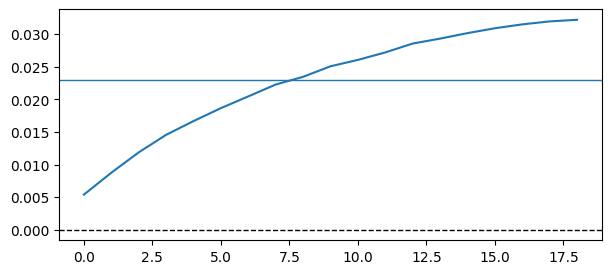

In [7]:
ind = np.where(G == 0)[0]
Y1 = Y[ind]
D1 = D[ind]
X11 = X[ind]
ones1 = ones[ind]

dml_npiv = DML_npiv(Y1, D1, ones1, ones1, V=X11, v_values = v_values,
                        estimator='OR',
                        loc_kernel='gau',
                        bw_loc='silverman',
                        model1 = m1,
                        modelq1 = m2,
                n_folds=10, n_rep=1, CHIM = False, prop_score=LogisticRegression(max_iter=2000), opts = {'lin_degree': 1})

theta_oracle, vart_oracle, ci_oracle = dml_npiv.dml()

lower_ci_oracle = ci_oracle[:, 0]
upper_ci_oracle = ci_oracle[:, 1]
yerr_oracle = [theta_oracle - lower_ci_oracle, upper_ci_oracle - theta_oracle]

plt.figure(figsize=(7, 3))
plt.plot(theta_oracle)
plt.axhline(np.mean(theta_oracle, axis=0), linewidth=1)  # Adjust line properties as needed
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Adjust line properties as needed

In [8]:
theta_oracle

array([0.00538572, 0.00874814, 0.01186356, 0.01455617, 0.01666301,
       0.01865331, 0.02045047, 0.02227007, 0.02345013, 0.02506653,
       0.02604769, 0.0271925 , 0.02855567, 0.02931114, 0.03015172,
       0.03090026, 0.03149578, 0.03194765, 0.03219928])